In [1]:
import numpy as np
from sklearn.datasets import make_circles
import matplotlib.pyplot as plt

In [ ]:
class SVM:
    def __init__(self, C=2, kernel='rbf', gamma=0.1, degree=1):
        self.C = C
        self.c = 1
        print('Kernel:', kernel)
        if kernel == 'poly':
            self.d = degree
            kernel = self._polynomial_kernel
        elif kernel == 'sigmoid':
            self.gamma = gamma
            kernel = self._sigmoid_kernel
        else:
            self.gamma = gamma
            kernel = self._rbf_kernel
        self.kernel = kernel
        self.X = None
        self.y = None
        self.n = None
        self.m = None
        self.lamda = None
        self.b = None
        self.ones = None
    def _polynomial_kernel(self, X1, X2):
        '''
        Request: X1, X2: N*m matrix
        Return: N * N matrix
        '''
        return (self.c + X1 @ X2.T) ** self.d
    def _sigmoid_kernel(self, X1, X2):
        return np.tanh(self.c + self.gamma * (X1 @ X2.T))
    def _rbf_kernel(self, X1, X2):
        '''
        To change the difference of two matrix:
        numpy support broadcasting difference, it means:
            + Request: X1, X2: N*M matrix
            + Explain:
                + X1 <- Nx1xM Matrix
                + X2 <- 1xNxM Matrix
                + X1 - X2 -> N x N x M matrix
                + Norm the difference by axis 2 (shape = M)
            + Return: N * N matrix
        '''
        
        return np.exp((-np.linalg.norm(X1[:, np.newaxis] - X2[np.newaxis, :], axis=2)**2) / (2 * self.gamma**2))
    
    def cost(self, kernel_matrix):
        return np.sum(self.lamda) - 0.5 * np.sum(np.outer(self.lamda, self.lamda) * kernel_matrix)
    def fit(self, X, y, schedule='step' ,lr=1e-3, epochs=1000, decay_rate=0.9):
        self.X = X
        self.y = y
        self.n = X.shape[0]
        self.m = X.shape[1]
        self.lamda = np.random.random(X.shape[0])
        self.b = 0
        self.ones = np.ones(self.n)
        
        # kernel_matrix = np.outer(y,y) * self.kernel(X, X)
        cost_values = []
       
        for epoch in range (epochs):
            # maximize L(lamda)
            batch_size = 64
            batch_idx = np.random.choice(self.n, batch_size, replace=False)
            X_batch = X[batch_idx]
            y_batch = y[batch_idx]
            lamda_batch = self.lamda[batch_idx]
            kernel_batch = np.outer(y_batch, y_batch) * self.kernel(X_batch, X_batch)

            grad = self.ones[batch_idx] - kernel_batch @ lamda_batch
            self.lamda[batch_idx] += lr * grad
            self.lamda[batch_idx] = np.clip(self.lamda[batch_idx], 0, self.C)

            cost = np.sum(lamda_batch) - 0.5 * np.sum(np.outer(lamda_batch, lamda_batch) * kernel_batch)
            # cost = self.cost(kernel_batch)
            if (len(cost_values) > 1) and (np.abs(cost_values[-1] - cost_values[-2]) < 1e-4):
                print('Coverage at ite:', epoch)
                break
            cost_values.append(cost)

            lr *= decay_rate
        support_vectors = np.where((self.lamda > 0) & (self.lamda < self.C))[0]
        if len(support_vectors) > 0:
            self.b = np.mean(y[support_vectors] - ((self.lamda * y) @ self.kernel(X, X[support_vectors])))
        else:
            print("No support vectors found.")
            self.b = 0
        # plt.plot(cost_values)
        # plt.title('Loss per epoch')
        # plt.show()
    def decision_function(self, X):
        return ((self.lamda * self.y) @ self.kernel(self.X, X)) + self.b
    def visualize(self):
        plt.scatter(self.X[:, 0], self.X[:, 1], c=self.y, s=50, cmap='autumn', alpha=.5)
        ax = plt.gca()
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        
        xx = np.linspace(xlim[0], xlim[1], 30)
        yy = np.linspace(ylim[0], ylim[1], 30)
        YY, XX = np.meshgrid(yy, xx)
        xy = np.vstack([XX.ravel(), YY.ravel()]).T 
        Z = self.decision_function(xy).reshape(XX.shape)
        
        ax.contour(XX, YY, Z, colors=['b', 'g', 'r'], levels=[-1, 0, 1], alpha=0.5, 
                   linestyles=['--', '-', '--'], linewidths=[2.0, 2.0, 2.0])
        ax.scatter(self.X[:, 0][self.lamda > 0.], self.X[:, 1][self.lamda > 0.], s=50,
                   linewidth=1, facecolors='none', edgecolors='k')
        plt.show()
    def predict(self, X):
        return np.sign(self.decision_function(X))
    def score(self, X, y):
        y_hat = self.predict(X)
        return np.mean(y == y_hat)
        

### Circle Dataset

Kernel: poly
Coverage at ite: 107


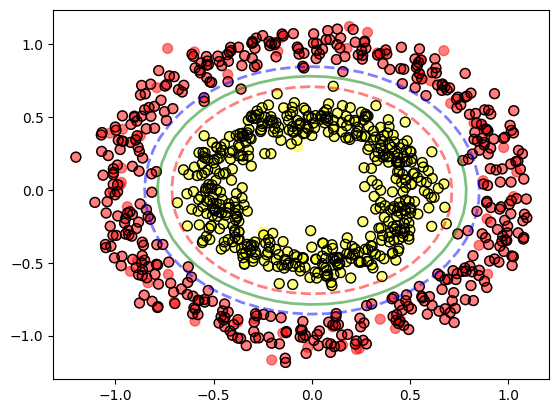

0.999


In [4]:
from sklearn.datasets import make_circles

X, y = make_circles(1000, factor=.5, noise=.08, random_state=42)
y[y ==0 ] = -1
svm = SVM(C=0.1, kernel='poly', degree=2)
svm.fit(X, y)
svm.visualize()
print(svm.score(X, y))

### Moon Dataset

In [5]:
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=100000, noise=0.1, random_state=42)
y[y == 0] = -1
svm = SVM(C=1, kernel='rbf', gamma=0.1)
svm.fit(X, y)
svm.visualize()
print(svm.score(X, y))


Kernel: rbf


: 

### Random Noise Dataset

Kernel: rbf
Coverage at ite: 120


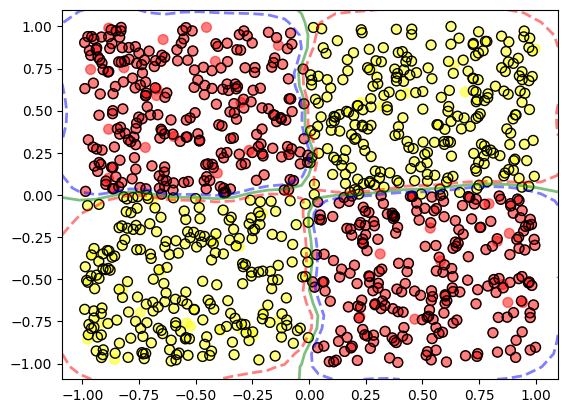

np.float64(0.988)

In [191]:
import numpy as np

np.random.seed(42)
X = np.random.rand(1000, 2) * 2 - 1 
y = np.sign(X[:, 0] * X[:, 1])  

svm = SVM(C=10 ,kernel='rbf', gamma=0.1, degree=2)
svm.fit(X, y)
svm.visualize()
svm.score(X, y)


Kernel: rbf
Coverage at ite: 132


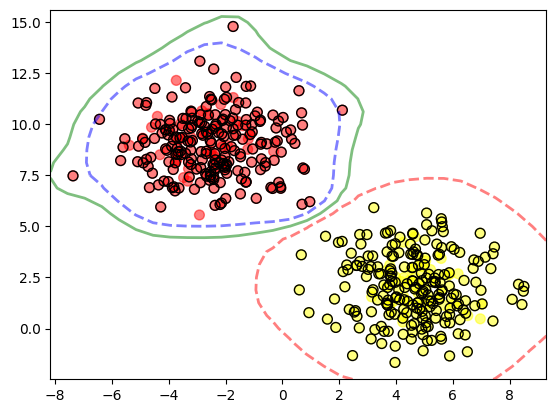

np.float64(1.0)

In [209]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=500, centers=2, random_state=42, cluster_std=1.5)
y[y == 0] = -1
svm = SVM(C=1 ,kernel='rbf',gamma=1, degree=1)
svm.fit(X, y)
svm.visualize()
svm.score(X, y)


### Iris Dataset With Two Labels

In [201]:
from sklearn.datasets import load_iris

iris = load_iris()
X = iris.data[iris.target != 2, :2]  # Chọn 2 lớp đầu tiên, 2 đặc trưng đầu tiên
y = iris.target[iris.target != 2]
y[y == 0] = -1
svm = SVM(C=0.1, kernel='rbf', gamma=1, degree=1)
svm.fit(X, y)
# svm.visualize()
svm.score(X, y)


Kernel: rbf
Coverage at ite: 59


np.float64(1.0)